In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# 🔹 1️⃣ Load the Iris dataset
iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=iris.feature_names)

# 🔹 2️⃣ Load the Mall Customers dataset
mall_data = pd.read_csv("mall_customers.csv")

# 🔹 3️⃣ Load the Spotify dataset (Limit the number of rows)
spotify_data = pd.read_csv("dataset.csv")

# Reduce Spotify dataset size to avoid MemoryError
spotify_sample_size = 5000  
if len(spotify_data) > spotify_sample_size:
    spotify_data = spotify_data.sample(n=spotify_sample_size, random_state=42)

# 🔹 4️⃣ Generate Synthetic Datasets
X_blobs, _ = make_blobs(n_samples=500, centers=3, random_state=42)
X_moons, _ = make_moons(n_samples=500, noise=0.05, random_state=42)
X_circles, _ = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)

# 🔹 5️⃣ Generate Gaussian Mixture Model Dataset (Fixed Version)
X_gmm_base, _ = make_blobs(n_samples=1000, centers=3, random_state=42)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_gmm_base)  # ✅ Fit the model first
X_gmm, _ = gmm.sample(n_samples=500)  # ✅ Now sample new points

# 🔹 6️⃣ Select Relevant Features for Real Datasets
mall_features = ["Annual Income (k$)", "Spending Score (1-100)"]  
spotify_features = ["danceability", "energy", "valence", "tempo"]

# 🔹 7️⃣ Standardizing the data
scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_data)
mall_scaled = scaler.fit_transform(mall_data[mall_features])
spotify_scaled = scaler.fit_transform(spotify_data[spotify_features])
blobs_scaled = scaler.fit_transform(X_blobs)
moons_scaled = scaler.fit_transform(X_moons)
circles_scaled = scaler.fit_transform(X_circles)
gmm_scaled = scaler.fit_transform(X_gmm)

# 🔹 8️⃣ Reduce Dimensionality for Spotify if needed
if spotify_scaled.shape[1] > 10:
    pca = PCA(n_components=10)
    spotify_scaled = pca.fit_transform(spotify_scaled)

# 🔹 9️⃣ Compute Dissimilarity Matrices
iris_dissimilarity = squareform(pdist(iris_scaled, metric="euclidean"))
mall_dissimilarity = squareform(pdist(mall_scaled, metric="euclidean"))
blobs_dissimilarity = squareform(pdist(blobs_scaled, metric="euclidean"))
moons_dissimilarity = squareform(pdist(moons_scaled, metric="euclidean"))
circles_dissimilarity = squareform(pdist(circles_scaled, metric="euclidean"))
gmm_dissimilarity = squareform(pdist(gmm_scaled, metric="euclidean"))

# Handle Large Spotify Data Using Approximate Nearest Neighbors
try:
    spotify_dissimilarity = squareform(pdist(spotify_scaled, metric="euclidean"))
except MemoryError:
    print("⚠️ Spotify dataset is too large. Using Approximate Nearest Neighbors instead.")
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=10, metric="euclidean").fit(spotify_scaled)
    distances, _ = nn.kneighbors(spotify_scaled)
    spotify_dissimilarity = distances  # Approximate dissimilarity matrix

# 🔹 🔟 Save preprocessed data
np.save("iris_dissimilarity.npy", iris_dissimilarity)
np.save("mall_dissimilarity.npy", mall_dissimilarity)
np.save("spotify_dissimilarity.npy", spotify_dissimilarity)
np.save("blobs_dissimilarity.npy", blobs_dissimilarity)
np.save("moons_dissimilarity.npy", moons_dissimilarity)
np.save("circles_dissimilarity.npy", circles_dissimilarity)
np.save("gmm_dissimilarity.npy", gmm_dissimilarity)

print("✅ All datasets loaded and preprocessed successfully!")


✅ All datasets loaded and preprocessed successfully!


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def vat(R):
    """
    Implements the VAT algorithm for Visual Assessment of Cluster Tendency.
    
    Parameters:
    R (numpy.ndarray): The NxN dissimilarity matrix.

    Returns:
    RV (numpy.ndarray): The VAT-reordered dissimilarity matrix.
    C (list): The cluster reordering indices.
    """
    N = R.shape[0]
    J = list(range(N))
    I = [np.argmax(np.sum(R, axis=1))]  # Start with the most distant point
    J.remove(I[0])

    RV = np.zeros_like(R)
    
    for _ in range(1, N):
        min_dists = [R[j, I].min() for j in J]
        j_star = J[np.argmin(min_dists)]
        I.append(j_star)
        J.remove(j_star)
    
    for i in range(N):
        for j in range(N):
            RV[i, j] = R[I[i], I[j]]
    
    return RV, I

def plot_vat(R, title="VAT Image"):
    """
    Plots the VAT-reordered dissimilarity matrix as a grayscale image.
    
    Parameters:
    R (numpy.ndarray): The VAT-reordered dissimilarity matrix.
    title (str): Title of the image plot.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(R, cmap="gray", aspect="auto")
    plt.title(title)
    plt.colorbar(label="Dissimilarity")
    plt.show()


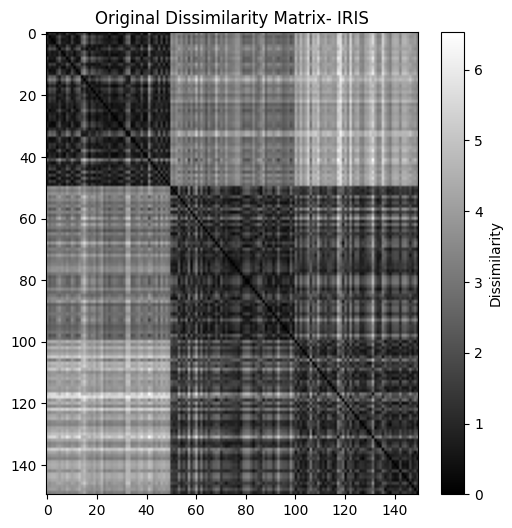

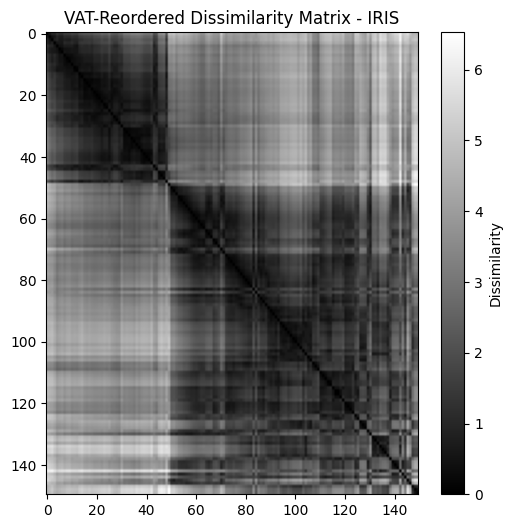

✅ VAT Algorithm Implemented Successfully!


In [18]:

# 🚀 Load Iris)
R = np.load("iris_dissimilarity.npy")

# 🚀 Apply VAT
RV, order = vat(R)

# 🚀 Plot Results
plot_vat(R, title="Original Dissimilarity Matrix- IRIS") 
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - IRIS")

print("✅ VAT Algorithm Implemented Successfully!")


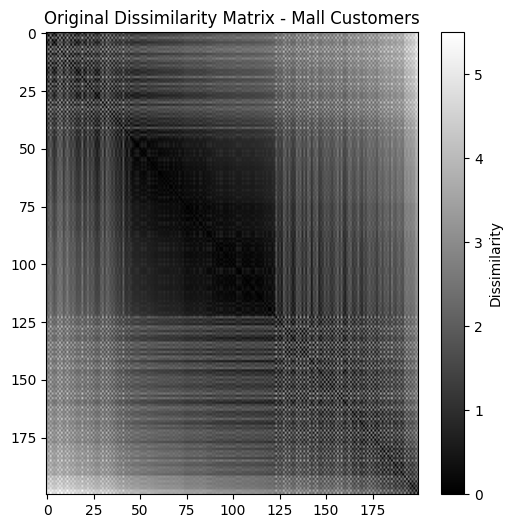

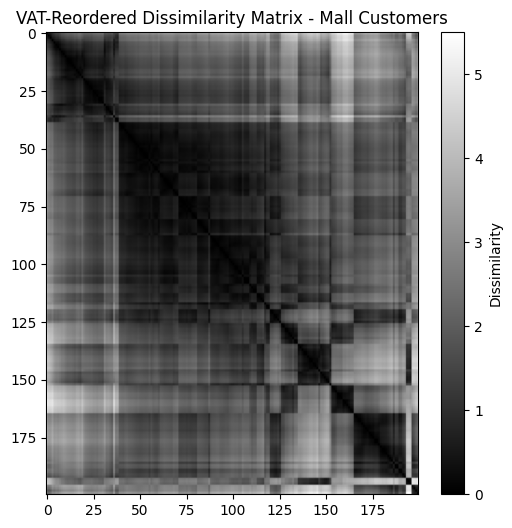

In [ ]:

R = np.load("mall_dissimilarity.npy")  # with Mall Customers dataset

# Apply VAT
RV, order = vat(R)

# Plot results
plot_vat(R, title="Original Dissimilarity Matrix - Mall Customers")
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - Mall Customers")


In [25]:
import numpy as np

# Load the original dissimilarity matrix
R_full = np.load("spotify_dissimilarity.npy")

# Select a 500x500 subset
subset_size = 500  # Reduced size
indices = np.random.choice(R_full.shape[0], subset_size, replace=False)
R_subset = R_full[np.ix_(indices, indices)]  # Take a subset of the matrix

# Save the smaller matrix for VAT
np.save("spotify_dissimilarity_subset.npy", R_subset)

print("✅ Reduced 500×500 Spotify dissimilarity matrix saved!")


✅ Reduced 500×500 Spotify dissimilarity matrix saved!


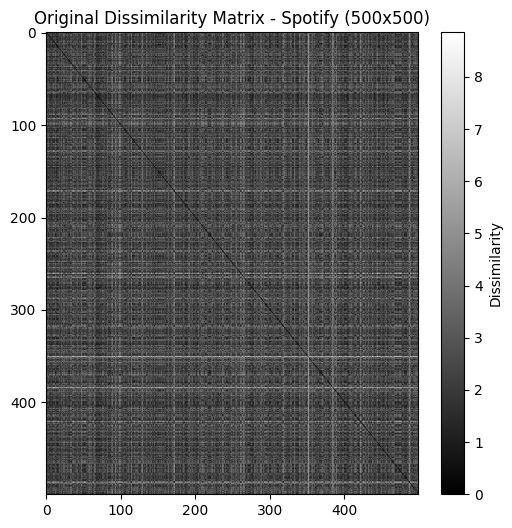

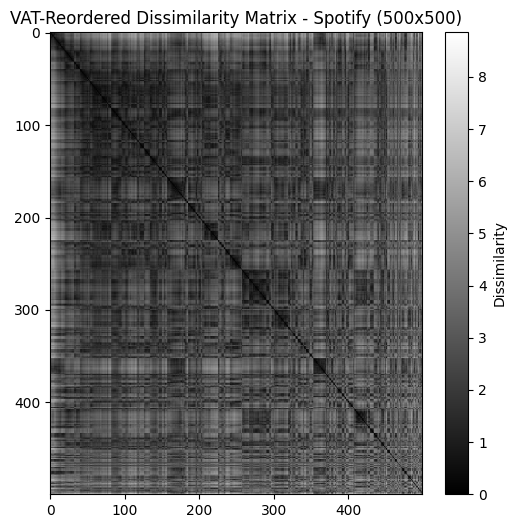

In [26]:
# Load reduced Spotify dissimilarity matrix
R = np.load("spotify_dissimilarity_subset.npy")  

# Apply VAT
RV, order = vat(R)

# Plot results
plot_vat(R, title="Original Dissimilarity Matrix - Spotify (500x500)")
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - Spotify (500x500)")


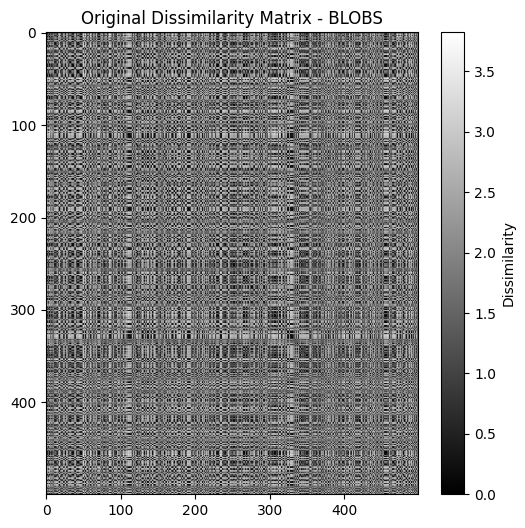

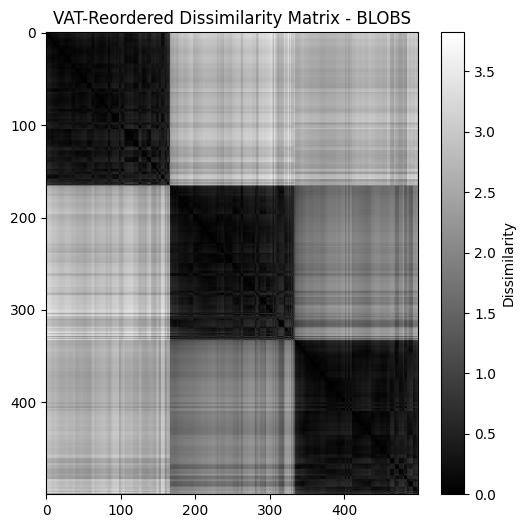

In [19]:
# Change the dataset file name to test different datasets
R = np.load("blobs_dissimilarity.npy")  # Try with Mall Customers dataset

# Apply VAT
RV, order = vat(R)

# Plot results
plot_vat(R, title="Original Dissimilarity Matrix - BLOBS")
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - BLOBS")


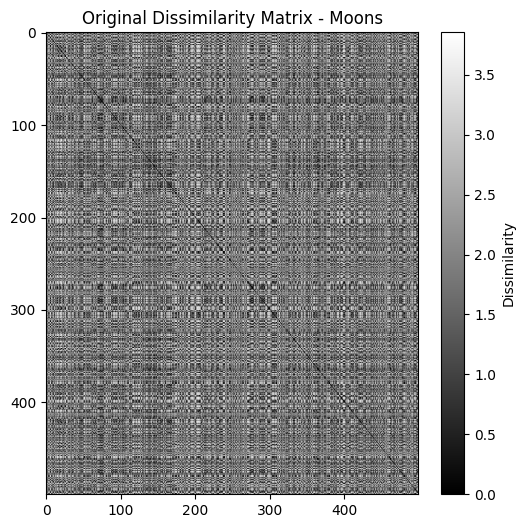

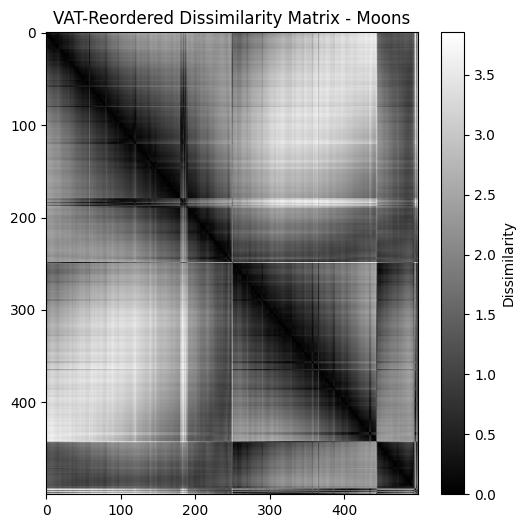

In [21]:

R = np.load("moons_dissimilarity.npy")  # with  Customers dataset

# Apply VAT
RV, order = vat(R)

# Plot results
plot_vat(R, title="Original Dissimilarity Matrix - Moons")
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - Moons")


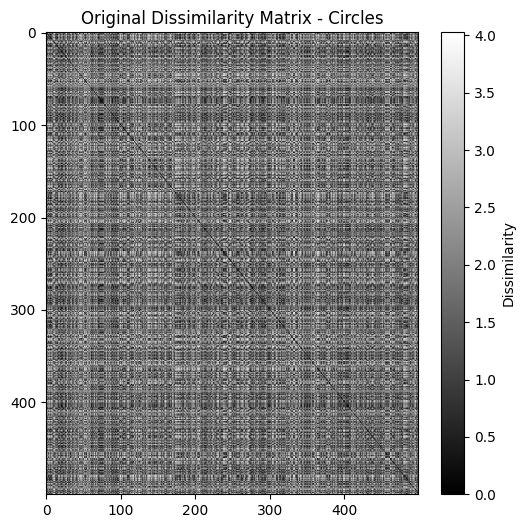

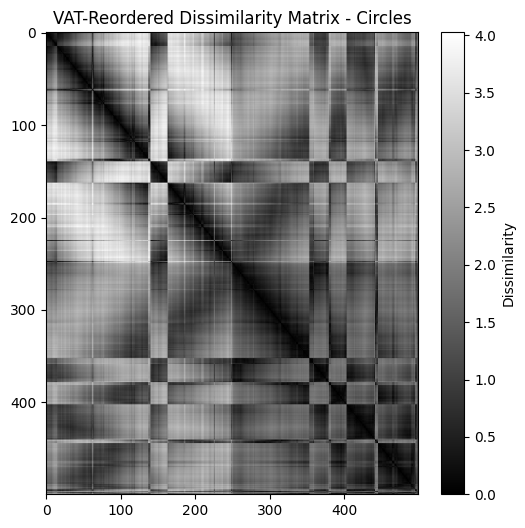

In [22]:

R = np.load("circles_dissimilarity.npy")  # with  Customers dataset

# Apply VAT
RV, order = vat(R)

# Plot results
plot_vat(R, title="Original Dissimilarity Matrix - Circles")
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - Circles")


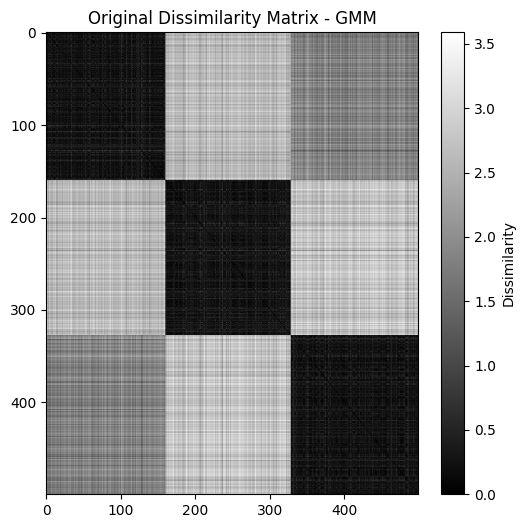

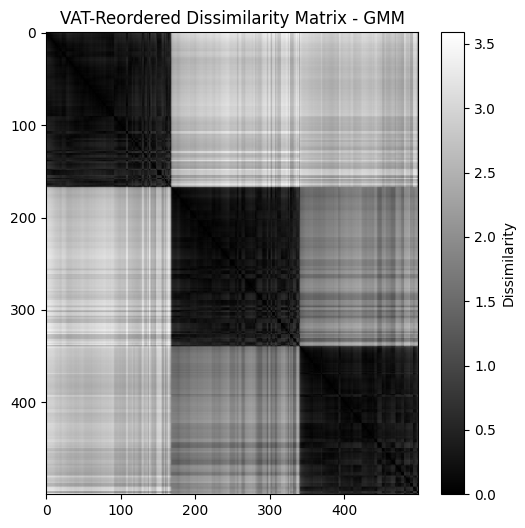

In [23]:

R = np.load("gmm_dissimilarity.npy")  # with  Customers dataset

# Apply VAT
RV, order = vat(R)

# Plot results
plot_vat(R, title="Original Dissimilarity Matrix - GMM")
plot_vat(RV, title="VAT-Reordered Dissimilarity Matrix - GMM")


In [28]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.manifold import MDS

def hopkins_statistic(X, sample_size=100):
    """
    Computes the Hopkins statistic to measure clustering tendency.

    Parameters:
    X (numpy.ndarray): The dataset (feature matrix, not dissimilarity matrix).
    sample_size (int): Number of random points to sample.

    Returns:
    float: Hopkins statistic (values close to 1 indicate strong clustering tendency).
    """
    n_samples = X.shape[0]
    if sample_size > n_samples:
        sample_size = n_samples // 2  # Adjust sample size if dataset is small

    # Step 1: Randomly select sample points
    sample_X = resample(X, n_samples=sample_size, random_state=42)

    # Step 2: Generate artificial points within the same feature space range
    min_vals, max_vals = X.min(axis=0), X.max(axis=0)
    random_points = np.random.uniform(min_vals, max_vals, (sample_size, X.shape[1]))

    # Step 3: Compute nearest neighbor distances for both real and artificial points
    nn = NearestNeighbors(n_neighbors=2).fit(X)
    real_dists, _ = nn.kneighbors(sample_X, n_neighbors=2)
    fake_dists, _ = nn.kneighbors(random_points, n_neighbors=1)

    # Step 4: Compute Hopkins statistic
    U = np.sum(fake_dists[:, 0])
    W = np.sum(real_dists[:, 1])  # Ignore first neighbor (itself)
    H = U / (U + W)

    return H

# 🚀 Load and compute Hopkins score for all datasets
datasets = {
    "Iris": np.load("iris_dissimilarity.npy"),
    "Mall Customers": np.load("mall_dissimilarity.npy"),
    "Spotify (500x500)": np.load("spotify_dissimilarity_subset.npy"),
    "Blobs": np.load("blobs_dissimilarity.npy"),
    "Moons": np.load("moons_dissimilarity.npy"),
    "Circles": np.load("circles_dissimilarity.npy"),
    "Gaussian Mixture": np.load("gmm_dissimilarity.npy")
}

# Compute and print Hopkins scores
for name, R in datasets.items():
    print(f"🔹 Processing {name}...")

    # Convert dissimilarity matrix into feature space using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    feature_approx = mds.fit_transform(R)  # Approximate feature representation

    # Compute Hopkins score
    hopkins_score = hopkins_statistic(feature_approx, sample_size=100)
    print(f"📌 Hopkins Score for {name}: {hopkins_score:.4f}\n")


🔹 Processing Iris...
📌 Hopkins Score for Iris: 0.8121

🔹 Processing Mall Customers...
📌 Hopkins Score for Mall Customers: 0.8154

🔹 Processing Spotify (500x500)...
📌 Hopkins Score for Spotify (500x500): 0.8684

🔹 Processing Blobs...
📌 Hopkins Score for Blobs: 0.9295

🔹 Processing Moons...
📌 Hopkins Score for Moons: 0.8955

🔹 Processing Circles...
📌 Hopkins Score for Circles: 0.7362

🔹 Processing Gaussian Mixture...
📌 Hopkins Score for Gaussian Mixture: 0.9458



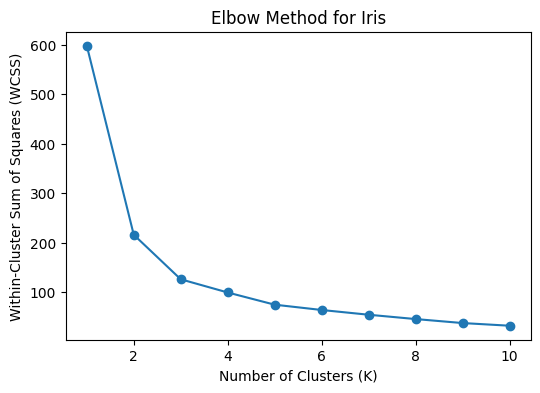

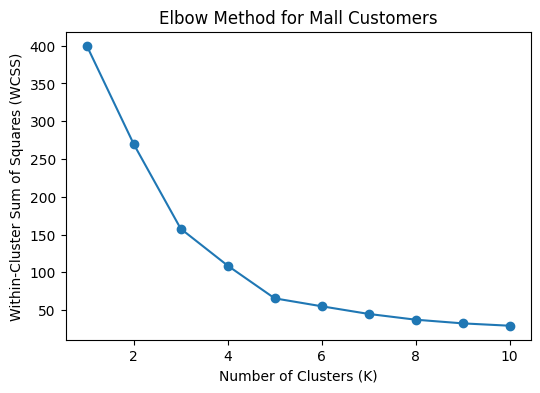

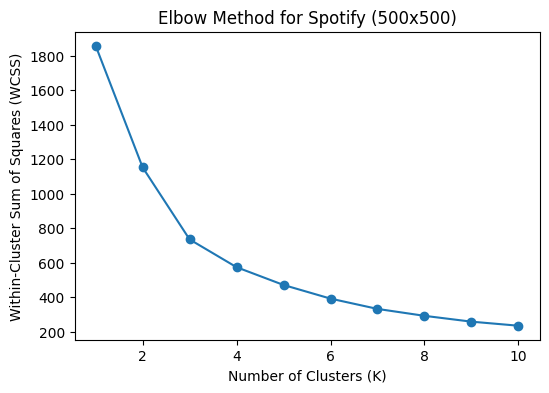

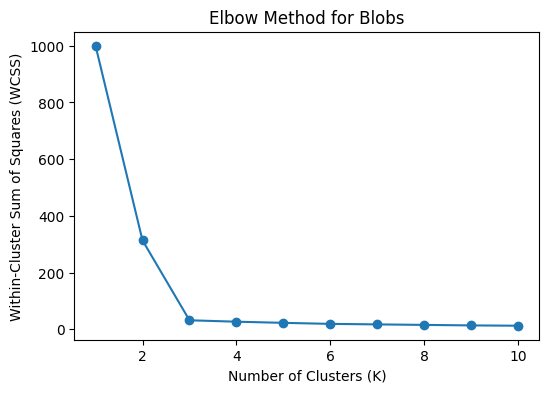

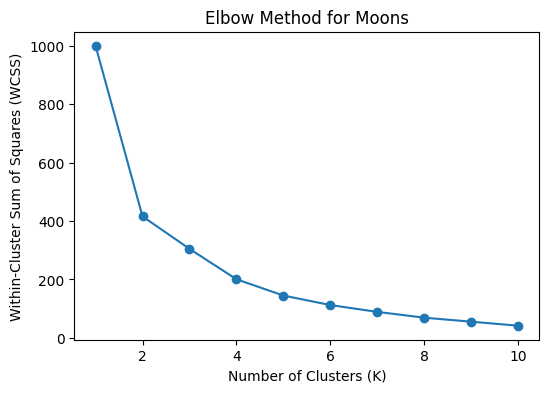

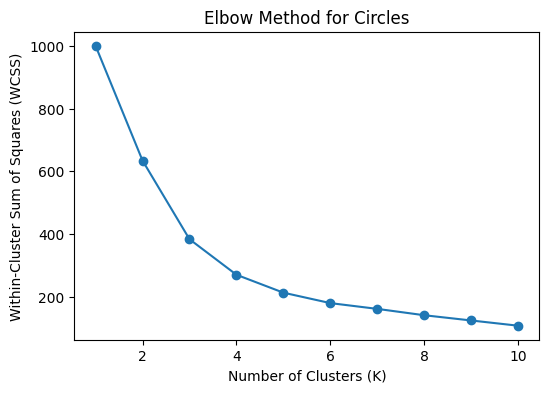

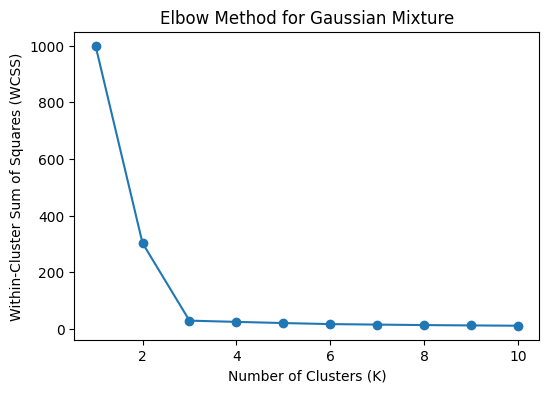

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

def elbow_method(R, dataset_name):
    """
    Computes the Elbow Method for finding the optimal K in K-Means.
    
    Parameters:
    R (numpy.ndarray): The dissimilarity matrix.
    dataset_name (str): The name of the dataset.
    
    Returns:
    None (Displays the Elbow plot)
    """
    # Convert dissimilarity matrix to feature space using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    feature_approx = mds.fit_transform(R)

    # Compute WCSS for K = 1 to 10
    wcss = []
    K_range = range(1, 11)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(feature_approx)
        wcss.append(kmeans.inertia_)  # Inertia = WCSS
    
    # Plot the Elbow Method result
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, wcss, marker='o', linestyle='-')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.title(f"Elbow Method for {dataset_name}")
    plt.show()

# 🚀 Run Elbow Method on all datasets
datasets = {
    "Iris": np.load("iris_dissimilarity.npy"),
    "Mall Customers": np.load("mall_dissimilarity.npy"),
    "Spotify (500x500)": np.load("spotify_dissimilarity_subset.npy"),
    "Blobs": np.load("blobs_dissimilarity.npy"),
    "Moons": np.load("moons_dissimilarity.npy"),
    "Circles": np.load("circles_dissimilarity.npy"),
    "Gaussian Mixture": np.load("gmm_dissimilarity.npy")
}

for name, R in datasets.items():
    elbow_method(R, name)


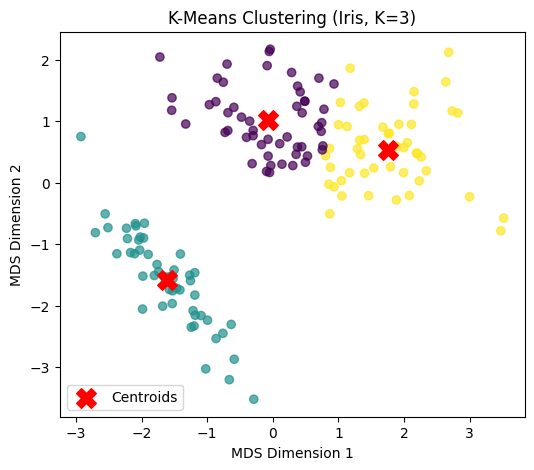

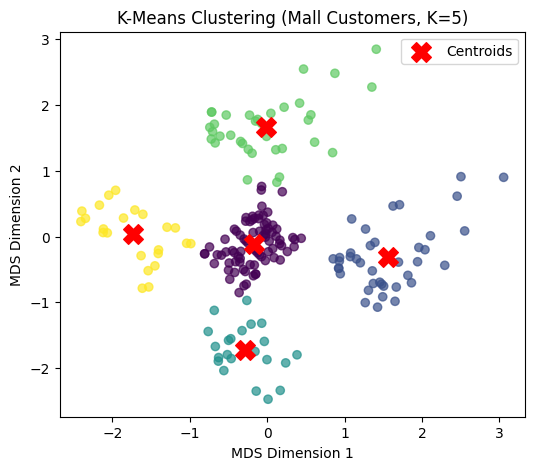

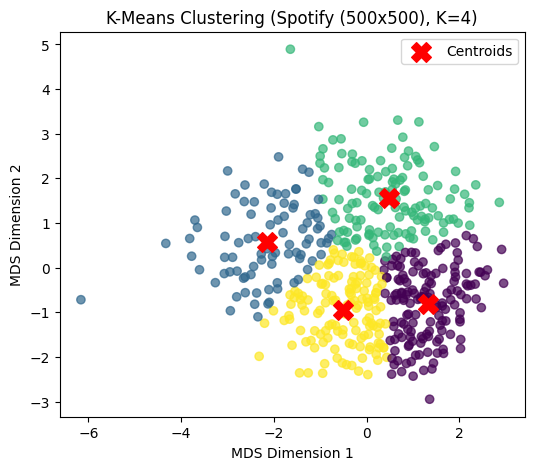

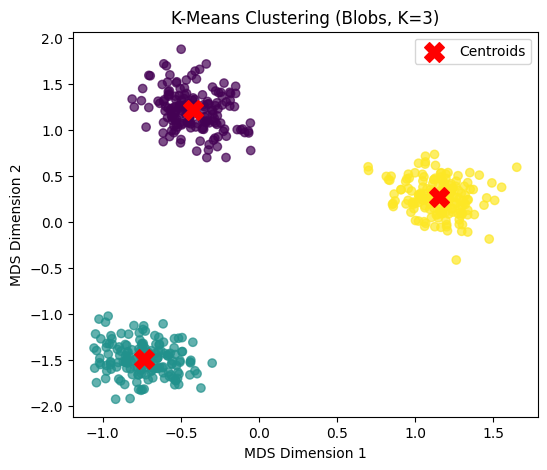

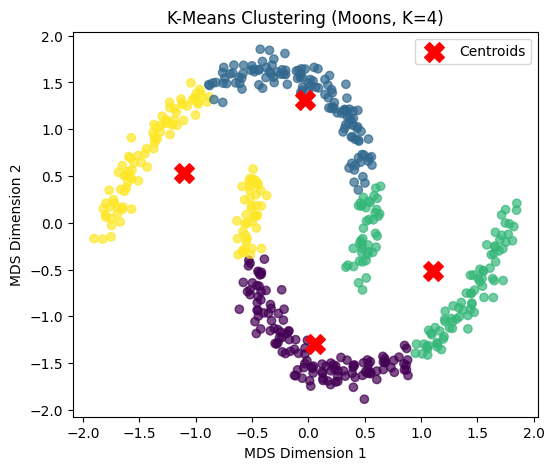

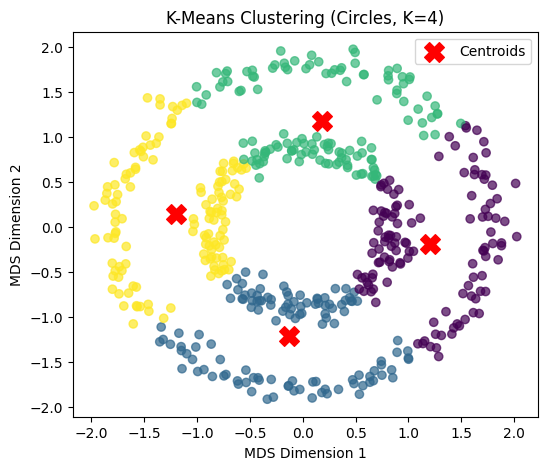

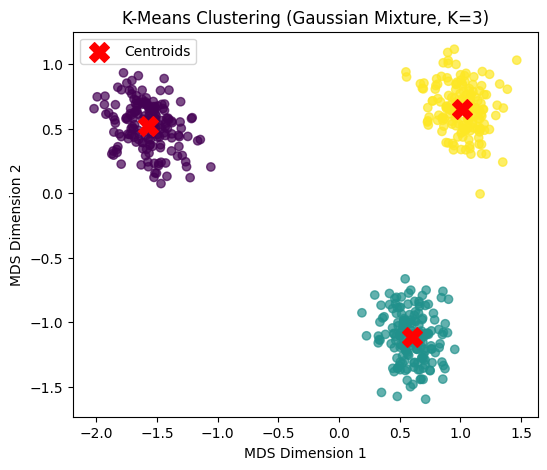

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

# Optimal K values from the Elbow Method
optimal_k_values = {
    "Iris": 3,
    "Mall Customers": 5,
    "Spotify (500x500)": 4,
    "Blobs": 3,
    "Moons": 4,
    "Circles": 4,
    "Gaussian Mixture": 3
}

def apply_kmeans(R, dataset_name, k):
    """
    Applies K-Means clustering and plots the resulting clusters.

    Parameters:
    R (numpy.ndarray): The dissimilarity matrix.
    dataset_name (str): Name of the dataset.
    k (int): Optimal number of clusters.

    Returns:
    None (Displays the cluster plot)
    """
    # Convert dissimilarity matrix to feature space using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    feature_approx = mds.fit_transform(R)

    # Apply K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(feature_approx)

    # Plot clusters
    plt.figure(figsize=(6, 5))
    plt.scatter(feature_approx[:, 0], feature_approx[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker="X", s=200, label="Centroids")
    plt.title(f"K-Means Clustering ({dataset_name}, K={k})")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.legend()
    plt.show()

# 🚀 Run K-Means on all datasets
datasets = {
    "Iris": np.load("iris_dissimilarity.npy"),
    "Mall Customers": np.load("mall_dissimilarity.npy"),
    "Spotify (500x500)": np.load("spotify_dissimilarity_subset.npy"),
    "Blobs": np.load("blobs_dissimilarity.npy"),
    "Moons": np.load("moons_dissimilarity.npy"),
    "Circles": np.load("circles_dissimilarity.npy"),
    "Gaussian Mixture": np.load("gmm_dissimilarity.npy")
}

for name, R in datasets.items():
    k = optimal_k_values[name]  # Get the best K from Elbow Method
    apply_kmeans(R, name, k)


C:\Users\admin\AppData\Local\Temp\ipykernel_14588\1054376296.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


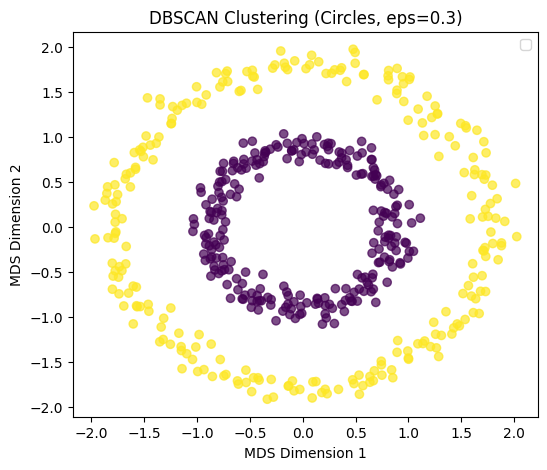

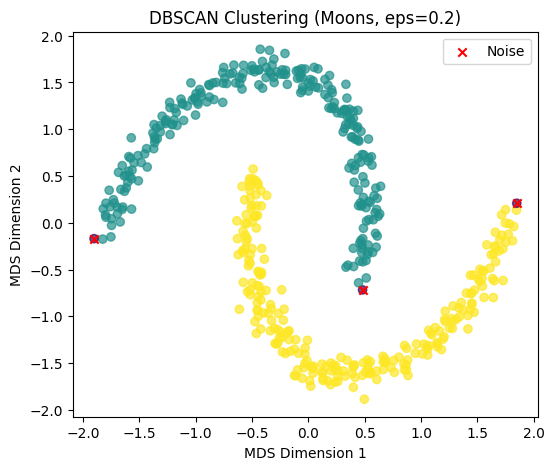

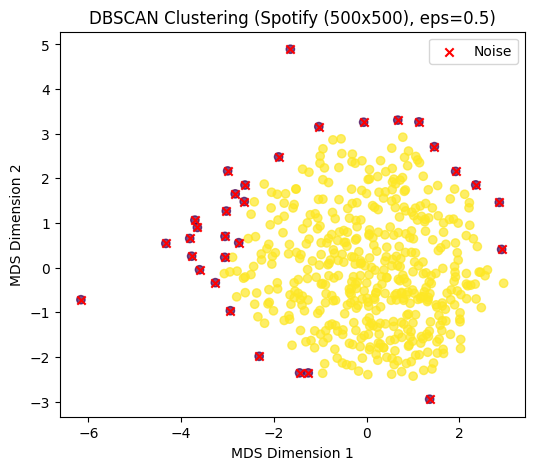

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS

# DBSCAN Parameters (Can be fine-tuned)
eps_values = {
    "Circles": 0.3,
    "Moons": 0.2,
    "Spotify (500x500)": 0.5  # Adjust as needed
}
min_samples = 10  # Minimum points to form a cluster

def apply_dbscan(R, dataset_name, eps):
    """
    Applies DBSCAN clustering and plots the results.

    Parameters:
    R (numpy.ndarray): The dissimilarity matrix.
    dataset_name (str): Name of the dataset.
    eps (float): DBSCAN's neighborhood radius.

    Returns:
    None (Displays the cluster plot)
    """
    # Convert dissimilarity matrix to feature space using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    feature_approx = mds.fit_transform(R)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(feature_approx)

    # Plot DBSCAN results
    plt.figure(figsize=(6, 5))
    plt.scatter(feature_approx[:, 0], feature_approx[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7)
    plt.title(f"DBSCAN Clustering ({dataset_name}, eps={eps})")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")

    # Mark noise points (-1 label)
    if -1 in cluster_labels:
        plt.scatter(feature_approx[cluster_labels == -1, 0], feature_approx[cluster_labels == -1, 1], 
                    color='red', marker='x', label='Noise')

    plt.legend()
    plt.show()

# 🚀 Apply DBSCAN to Circles, Moons, and Spotify
datasets = {
    "Circles": np.load("circles_dissimilarity.npy"),
    "Moons": np.load("moons_dissimilarity.npy"),
    "Spotify (500x500)": np.load("spotify_dissimilarity_subset.npy")
}

for name, R in datasets.items():
    eps = eps_values[name]  # Get optimal eps
    apply_dbscan(R, name, eps)


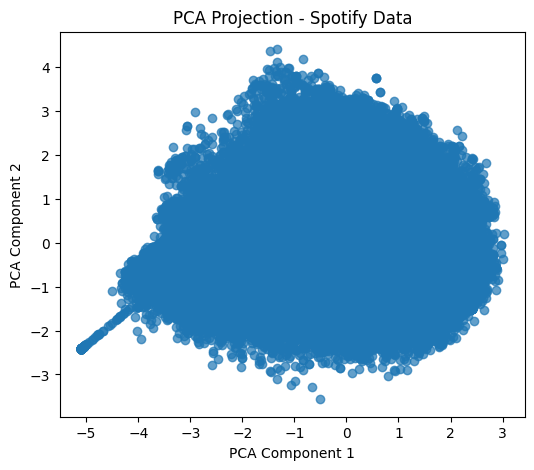

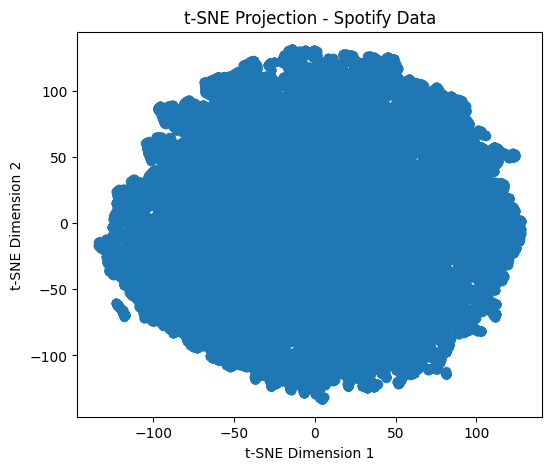

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load Spotify dataset (original feature space, not dissimilarity matrix)
spotify_data = pd.read_csv("dataset.csv")

# Select relevant features
spotify_features = ["danceability", "energy", "valence", "tempo"]  # Adjust if needed
spotify_scaled = StandardScaler().fit_transform(spotify_data[spotify_features])

# 🚀 Apply PCA
pca = PCA(n_components=2)
spotify_pca = pca.fit_transform(spotify_scaled)

# 🚀 Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
spotify_tsne = tsne.fit_transform(spotify_scaled)

# Plot PCA results
plt.figure(figsize=(6, 5))
plt.scatter(spotify_pca[:, 0], spotify_pca[:, 1], alpha=0.7)
plt.title("PCA Projection - Spotify Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Plot t-SNE results
plt.figure(figsize=(6, 5))
plt.scatter(spotify_tsne[:, 0], spotify_tsne[:, 1], alpha=0.7)
plt.title("t-SNE Projection - Spotify Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
